In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## a) load/merge data and visualize logerror

In [132]:
# load data into DataFrames
df1=pd.read_csv("train.csv")
df2=pd.read_csv("properties.csv")
df_final = df1.merge(df2, on = 'id', how = 'left')

In [133]:
# eliminate outliers
LE1=np.percentile(df_final.iloc[:,1],1,interpolation='nearest')
LE99=np.percentile(df_final.iloc[:,1],99,interpolation='nearest')
logerr=np.array(df_final.iloc[:,1])
logerr[np.where(logerr>=LE99)]=LE99
logerr[np.where(logerr<=LE1)]=LE1

df_final.iloc[:,1]=logerr
                   

Text(0.5, 1.0, 'Log Error')

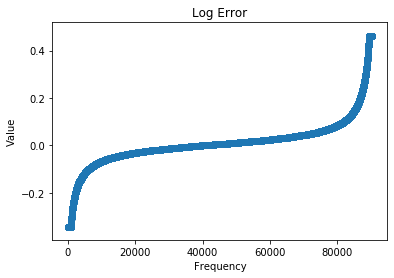

In [134]:
# scatter of logerr
a = df_final.iloc[:,1]
plt.scatter(np.arange(len(df_final)), np.sort(a))
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Log Error')

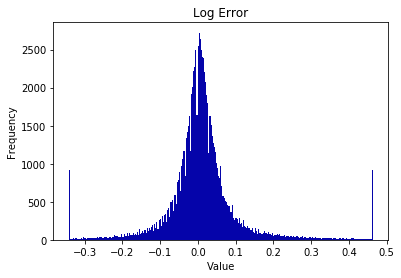

In [135]:
# histogram of logerr
n, bins, patches = plt.hist(df_final.iloc[:,1], bins='auto', color='#0504aa')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log Error')
maxfreq = n.max()

## b) data cleaning

In [136]:
# build new data frame
df_1=np.array(df_final.columns)
df_2=np.array(df_final.isnull().sum(axis = 0))
df_11=np.column_stack((df_1,df_2))
df_12=pd.DataFrame(df_11)
df_12.columns = ["column_name", "missing_count"]
df_12['missing_ratio'] = df_12.iloc[:,1]/len(df_final)
print(df_12)

                     column_name missing_count missing_ratio
0                             id             0             0
1                       logerror             0             0
2                transactiondate             0             0
3          airconditioningtypeid         80113      0.887433
4       architecturalstyletypeid         90178      0.998926
5                   basementsqft         90261      0.999845
6                    bathroomcnt         58550      0.648574
7                     bedroomcnt         58550      0.648574
8            buildingclasstypeid         90267      0.999911
9          buildingqualitytypeid         70038      0.775829
10             calculatedbathnbr         58964       0.65316
11                    decktypeid         90052       0.99753
12      finishedfloor1squarefeet         87931      0.974035
13  calculatedfinishedsquarefeet         58778      0.651099
14          finishedsquarefeet12         60197      0.666818
15          finishedsqua

In [137]:
df_final=df_final.fillna(df_final.mean())

## c) univariate analysis

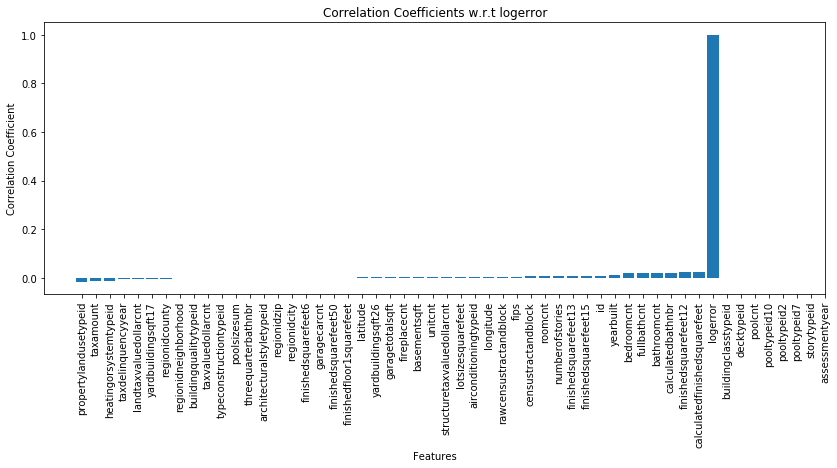

In [138]:
# make bar chart
correlation = df_final.corr().iloc[1,:]
correlation.sort_values(ascending=True, inplace=True)
plt.figure(figsize = (14,5))
plt.bar(np.arange(54),np.sort(correlation.values))
plt.title('Correlation Coefficients w.r.t logerror')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(np.arange(54),correlation.keys(),rotation = 'vertical')
plt.show()


# explain reason

From the graph we can see that there are columns without any value of correlation. If we look at the data of these features, we find all the values of these fatures are the same. There is no change in values (variance) hence the correlation coefficient value with logerror is is NaN resulting in missing correaltion coefficient.

## d) non-linear regression model

In [139]:
df_final=df_final.drop(["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag","id","transactiondate"], axis=1)
y=df_final.iloc[:,0]
x=df_final.iloc[:,1:]

In [140]:
# split and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.30)

In [141]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
fi=rf.feature_importances_
y_pred=rf.predict(X_test)

C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.010475270588728618


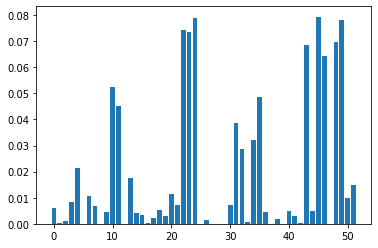

In [142]:
# report importances and mse
plt.bar(np.arange(len(fi)),fi)
from sklearn.metrics import mean_squared_error as mse
MSE1=mse(y_test,y_pred)
print(MSE1)

## e) KFold

In [143]:
# KFold, k = 5
datax=np.array(x.iloc[:500,:])
datay=np.array(y.iloc[:500])
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,shuffle=True)
MSE=[]
for a,b in kf.split(datax):
    trainx=datax[a,:]
    trainy=datay[a]
    testx=datax[b,:]
    testy=datay[b]
    rf.fit(trainx,trainy)
    fi=rf.feature_importances_
    ypred=rf.predict(testx)
    MSE2=mse(testy,ypred)
    MSE.append(MSE2)

MSE=np.array(MSE)

print('MSE for KFold:',MSE,'Avg MSE:',np.mean(MSE))


MSE for KFold: [0.01251576 0.01148013 0.0064085  0.00962729 0.01155723] Avg MSE: 0.0103177817836436


In [144]:
# Run d2 for 100 times
MSE_list=[]
for i in range(100):
    Xtrain,Xtest,ytrain,ytest=train_test_split(datax,datay,test_size=0.3,random_state=i)
    rf = RandomForestRegressor(random_state = i)
    rf.fit(Xtrain,ytrain)
    fi=rf.feature_importances_
    ypred1=rf.predict(Xtest)
    MSE3=mse(ytest,ypred1)
    MSE_list.append(MSE3)
    
MSE_list
    

C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mohan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.012061375227502174,
 0.01238404839507565,
 0.009757195579127425,
 0.009982592264602654,
 0.00971437781237707,
 0.013108918708190255,
 0.014059471380348455,
 0.014387240840575277,
 0.010612758897975855,
 0.009974540830847768,
 0.010939235820424357,
 0.010001761960604707,
 0.010056262720859542,
 0.006474531468530929,
 0.01251384120369906,
 0.007644469659575878,
 0.009421651911738157,
 0.009488837650338604,
 0.00942500872646759,
 0.008601529906074129,
 0.01364430968431742,
 0.008876130717341536,
 0.012079045482951984,
 0.011608889062973674,
 0.008581063169112045,
 0.0098001584848041,
 0.00852647815424317,
 0.008063283538660662,
 0.01230811828921441,
 0.010171141670555484,
 0.013186805373276805,
 0.009124226564229655,
 0.013089466763846657,
 0.007594882713935564,
 0.007493272174276747,
 0.014200948194069973,
 0.01173791198165334,
 0.0101991701688454,
 0.007482180298520437,
 0.012568526973940413,
 0.010071199285177936,
 0.010030386369471385,
 0.01173209160545139,
 0.008680805311553276,
 

In [145]:
minMSE=min(MSE_list)
maxMSE=max(MSE_list)
print("Min MSE from list"+str(minMSE))
print("Max MSE from list"+str(maxMSE))

Min MSE from list0.006474531468530929
Max MSE from list0.015920203689387867


# Findings

MSE is different for each seed. This variation can affect the understanding of the results. To overcome this, Cross Validation is used. Cross-validation splits dataset into train and test in KFold and every data points get to be tested exactly once and is used in training k-1 times. This helps in generalization and reduces the bias.